# Content

1 Data preparation

2 Task research

3 Fighting the imbalance

4 Testing the model

5 Conclusions

# Customer Exit Prediction Model

Customers began to leave a Bank, every month. A little, but noticeable. Bank marketers have calculated that it is cheaper to retain current customers than to attract new ones.

The task is to predict whether the client will leave the bank in the near future or not. I will be working with historical data on the behavior of customers and the termination of contracts with the bank.

I am going to build a model with an extremely large value of the F1-measure. What I want to do is bring the metric to 0.59 minimum.

Additionally, I will measure the AUC-ROC, and compare its value with the F1-measure.

Data source: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

# Data preparation

In the first place, I am going to import the libraries.

In [7]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, roc_curve

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler

import pandas as pd

from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

import warnings 

warnings.filterwarnings("ignore")

We store the data in a variable for further processing.

In [4]:
data = pd.read_csv(r'C:\Users\pinos\Desktop\statistics\Churn (1).csv')

Now we look at the data with a loop. We are going to see basics descriptives statistics, the type of data we have, and the missing values.

In [9]:
for i in data:
    
    data.describe()
    
    data.info()
    
    data.isna().mean()
    
    print(data)    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 976.6+ KB
      RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             

We only have missing values in the Tenure(0.09) column. There is relatively few missing values (less than 10%) so we proceed to remove it from the dataset.

In [10]:
data = data.dropna(subset=['Tenure'], inplace=False)

The data types seem to be fine, so we're leaving them as they are. However, we're going to change the column names to match python's stylistic standards.

In [11]:
data.columns = data.columns.str.lower()

We remove those columns that are not relevant to the analysis.

In [12]:
data.drop(["rownumber", "customerid", "surname"], axis=1, inplace=True)

In [14]:
data = data.rename(columns={
 
    'creditscore':'credit_score', 
    
    'numofproducts':'num_of_products',
     
    'hascrcard': 'has_cr_card',

    'isactivemember': 'is_active_member',
    
     'estimatedsalary': 'estimated_salary'})

In [15]:
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Everything looks fine.

We move on to the one hot encoding phase preprocessing.

In [18]:
data = pd.get_dummies(data, drop_first=True)

In [19]:
data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Looks good!

We divide the initial data into three samples:

- Training sample: 60% (features_train, target_train)

- Validation sample: 20% (features_valid, target_valid)

- Test sample: 20% (features_test, target_test)

In [20]:
features = data.drop('exited', axis=1)

target = data['exited']

In [21]:
features_train, features_test0, target_train, target_test0 = train_test_split(
    
    features, target, 
                                                                              
    test_size=0.4, 
                                                                              
    random_state=1)

In [22]:
features_valid, features_test, target_valid, target_test = train_test_split(
    
    features_test0, 
                                                                                                                                                    
    target_test0, 
                                                                                                                                                    
    test_size=0.5, 
                                                                                                                                                    
    random_state=1)

In [24]:
print(features_train.shape, 
      
      target_train.shape, 
      
      features_valid.shape, 
      
      target_valid.shape, 
      
      features_test.shape, 
      
      target_test.shape)

(5454, 11) (5454,) (1818, 11) (1818,) (1819, 11) (1819,)


The shape seems to be correct.

Let's start standardizing signs, to do that we will create a list with the names of the columns that we are interested in standardizing.

In [25]:
numeric = [
    
    'credit_score', 
    
    'age', 
    
    'tenure', 
    
    'num_of_products', 
    
    'balance', 
    
    'estimated_salary'
]

In [26]:
pd.options.mode.chained_assignment = None

In [27]:
scaler = StandardScaler()

scaler.fit(features_train[numeric]) 

StandardScaler()

In [28]:
features_train[numeric] = scaler.transform(features_train[numeric])

features_valid[numeric] = scaler.transform(features_valid[numeric])

features_test[numeric] = scaler.transform(features_test[numeric])

In [29]:
display(features_train.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6211,-1.548236,0.098891,0.700588,0.649101,-0.904733,0,0,1.667344,1,0,0
7540,-1.017557,-0.185978,-1.381516,-1.238754,-0.904733,1,0,-1.229687,0,0,1
129,1.240430,-1.420411,1.394623,0.400016,-0.904733,1,0,1.160293,0,0,1
3298,-0.965530,-1.325455,1.741641,0.553486,0.811585,1,0,1.684571,1,0,1
9653,-1.288099,1.808106,-0.687481,0.971202,-0.904733,1,1,0.442025,1,0,1


In this first section, we explored the variables in the dataset and dealt with missing values.

In addition, we adapted the python-style column names, lowercase letters and snake case.

We also applied the one hot encoder method to be able to better process the data in the next stages of the study.

As a preliminary step in the training phase of the model, we divided the dataset into three parts: train, validate, and test.

Finally, we converted the categorical variables into numbers so that the program could read them correctly, thus completing the data preparation.

# Task research

We start choosing the best model out of three: DecisionTreeClassifier, RandomForestClassifier, LogisticRegression.

First we are going to explore the best implementation depth of models.

In [30]:
for depth in range(1, 11):
    
    model_tree = DecisionTreeClassifier(
        
        random_state=12345, 
        
        splitter='best', 
        
        max_depth = depth) 
    
    model_tree.fit(features_train, target_train)
    
    predictions_valid = model_tree.predict(features_valid)  
    
    print('max_depth =', depth, ': ', end ='')
    
    print(f1_score(target_valid, predictions_valid))

max_depth = 1 : 0.0
max_depth = 2 : 0.4657039711191336
max_depth = 3 : 0.45818181818181813
max_depth = 4 : 0.36942675159235666
max_depth = 5 : 0.4132231404958678
max_depth = 6 : 0.49084249084249076
max_depth = 7 : 0.5064220183486238
max_depth = 8 : 0.4957264957264957
max_depth = 9 : 0.4777070063694268
max_depth = 10 : 0.5039619651347068


Depth 7 is the one that works best for the tree model. We are going to apply it for F1 and Auc Roc.

In [31]:
model = DecisionTreeClassifier(max_depth = 7, random_state=12345)

model.fit(features_train, target_train)

predicted_valid_tree = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid_tree))

0.5064220183486238


In [33]:
model = DecisionTreeClassifier(max_depth = 7, random_state=12345)

model.fit(features_train, target_train)

probabilities_valid_tree = model.predict_proba(features_valid)

probabilities_one_valid_tree = probabilities_valid_tree[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid_tree)

print(auc_roc)

0.8021889412060447


We continue the same steps with the forest model, but this time with two nested loops.

In [34]:
best_model = None
best_result = 0
best_est = 0
best_depth = 0

for est in range(10, 51, 10):
    
    for depth in range(1, 11):
        
        model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        
        model_forest.fit(features_train, target_train)
        
        predictions_valid = model_forest.predict(features_valid)
        
        result = f1_score(target_valid, predictions_valid)
    
        if result > best_result:
            
            best_model = model_forest
            
            best_result = result
            
            best_est = est
            
            best_depth = depth
            
print("Number of trees:", best_est)

print("Best tree depth:", best_depth)

print("F1:", best_result)

Number of trees: 30
Best tree depth: 10
F1: 0.5330882352941176


We apply optimal parameters to the model to train it.

In [35]:
model = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=10)

model.fit(features_train, target_train)

probabilities_valid_forest = model.predict_proba(features_valid)

probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid_forest)

print(auc_roc)

0.8479768730240066


As we can see, the forest model performs better than the tree model in the two measures studied.

In [36]:
model = LogisticRegression(random_state=12345, solver='liblinear')

model.fit(features_train, target_train)

predicted_valid_lr = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid_lr))

0.2594142259414226


In [37]:
model = LogisticRegression(random_state=12345, solver='liblinear')

model.fit(features_train, target_train)

probabilities_valid_lr = model.predict_proba(features_valid)

probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid_lr)

print(auc_roc)

0.7561360933587291


The logistic regression model is the one that performs the worst.

# Fighting the imbalance

Let's see how distributed the data is.

In [38]:
freq = data['exited'].value_counts(normalize=True)

print(freq)

0    0.796062
1    0.203938
Name: exited, dtype: float64


<AxesSubplot:>

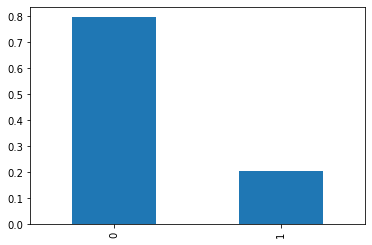

In [39]:
freq.plot(kind='bar')

In [40]:
freq_train = target_train.value_counts(normalize=True)

print(freq_train)

0    0.794096
1    0.205904
Name: exited, dtype: float64


<AxesSubplot:>

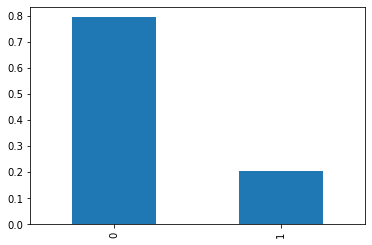

In [41]:
freq_train.plot(kind='bar')

In [42]:
freq_valid = target_valid.value_counts(normalize=True)

print(freq_valid)

0    0.805831
1    0.194169
Name: exited, dtype: float64


<AxesSubplot:>

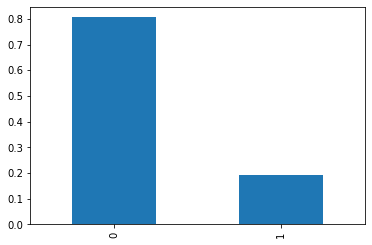

In [43]:
freq_valid.plot(kind='bar')

We don't see much difference when compared to the target frequencies, a 80/20 ratio.

We apply the upsample technique to see what it offers us.

In [44]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    
    features_ones = features[target == 1]
    
    target_zeros = target[target == 0]
    
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, 
                                                   
                                                   target_upsampled, 
                                                   
                                                   random_state=42)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [45]:
print(target_upsampled.shape)

print(target_upsampled.value_counts())

(8823,)
1    4492
0    4331
Name: exited, dtype: int64


We see how the sample is more balanced with this technique.

Now we apply downsampled with the same procedure and the same function scheme.

In [46]:
def downsample(features, target, fraction):
    
    features_zeros = features[target == 0]
    
    features_ones = features[target == 1]
    
    target_zeros = target[target == 0]
    
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    
    target_downsampled = pd.concat(
        
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, 
                                                      
                                                                  target_train, 
                                                      
                                                      fraction=0.25 
                                                       
                                                     )

In [47]:
print(target_downsampled.shape)

print(target_downsampled.value_counts())

(2206,)
1    1123
0    1083
Name: exited, dtype: int64


The sample is balanced and reduced as expected.

We first apply upsample to the tree model and see its performance.

In [48]:
model = DecisionTreeClassifier(max_depth = 7, random_state=12345)

model.fit(features_upsampled, target_upsampled)

predicted_valid_tree = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid_tree))

0.5508571428571428


We fall short as our goal is to get at least a 0.59.

In [49]:
model = DecisionTreeClassifier(max_depth = 7, random_state=12345)

model.fit(features_upsampled, target_upsampled)

probabilities_valid_tree = model.predict_proba(features_valid)

probabilities_one_valid_tree = probabilities_valid_tree[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid_tree)

print(auc_roc)

0.8035521952257104


For auc_roc_score however, this model does not work badly.

We follow the same steps for the forest model.

In [51]:
model = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=10)

model.fit(features_upsampled, target_upsampled)

predicted_valid_forest = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid_forest))


0.6085825747724318


This model does reach the goal.

In [52]:
model = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=10)

model.fit(features_upsampled, target_upsampled)

probabilities_valid_forest = model.predict_proba(features_valid)

probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid_forest)

print(auc_roc)


0.8385510833518646


And performs better in auc_roc metric.

No, we take a look to the linear regression model.

In [54]:
model = LogisticRegression(random_state=12345, solver='liblinear')

model.fit(features_upsampled, target_upsampled)

predicted_valid_lr = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid_lr))

0.4692849949647533


In [55]:
model = LogisticRegression(random_state=12345, solver='liblinear')

model.fit(features_upsampled, target_upsampled)

probabilities_valid_lr = model.predict_proba(features_valid)

probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid_lr)

print(auc_roc)

0.7563023910121919


Not very well.

Let's take a look at the model tree with downsampling.

In [56]:
model = DecisionTreeClassifier(max_depth = 7, random_state=12345)

model.fit(features_downsampled, target_downsampled)

predicted_valid_tree = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid_tree))

0.5348595213319458


In [57]:
model = DecisionTreeClassifier(max_depth = 7, random_state=12345)

model.fit(features_downsampled, target_downsampled)

probabilities_valid_tree = model.predict_proba(features_valid)

probabilities_one_valid_tree = probabilities_valid_tree[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid_tree)

print(auc_roc)

0.8158717574374692


Not quite.

Now the forest model.

In [59]:
model = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=10)

model.fit(features_downsampled, target_downsampled)

predicted_valid_forest = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid_forest))

0.5592105263157895


In [58]:
model = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=10)

model.fit(features_downsampled, target_downsampled)

probabilities_valid_forest = model.predict_proba(features_valid)

probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid_forest)

print(auc_roc)

0.8374633806765994


The f1_score does not reach what is required.

In [60]:
model = LogisticRegression(random_state=12345, solver='liblinear')

model.fit(features_downsampled, target_downsampled)

predicted_valid_lr = model.predict(features_valid)

print(f1_score(target_valid, predicted_valid_lr))

0.4724724724724725


In [61]:
model = LogisticRegression(random_state=12345, solver='liblinear')

model.fit(features_downsampled, target_downsampled)

probabilities_valid_lr = model.predict_proba(features_valid)

probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

auc_roc=roc_auc_score(target_valid, probabilities_one_valid_lr)

print(auc_roc)

0.7542797474596101


The regression model even less so.

After balancing with downsampling and upsampling methods, we can see how the scores improve across all models. We also see how we get the best results with the upsampling method. However, the model that shows the most performance is the random forest model, and that is what we are going to test to see if it fits the most optimal conditions.

# Testing the model

In [62]:
model = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=10)

model.fit(features_upsampled, target_upsampled)

predictions = model.predict(features_test)

print("F1:", f1_score(predictions, target_test))

F1: 0.6035928143712576


In [66]:
model = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=10)

model.fit(features_upsampled, target_upsampled)

probabilities_test_lr = model.predict_proba(features_test)

probabilities_one_test_lr = probabilities_test_lr[:, 1]

auc_roc=roc_auc_score(target_test, probabilities_one_test_lr)

print(auc_roc)

0.852463199791444


As we can see, both one metric and another meet all the criteria set out in the task.

We conducted the study in several stages. We first removed the missing values that we found in the dataset. Second, we applied an ordinal encoder to avoid problems when applying linear and regression models with categorical variables.

Another important point of the study was data splitting, we used 40 percent of the data to train the model, leaving the rest for verification.

In the study, we tested three models: Decision Tree Classifier, Random Forest Classifier, and Logistic Regression. The first two are classification models and the last one is regression.

We used a loop to search the best parameters for our models.

Once, applied the best parameters, the most accurate model was the RandomForestClassifier model.

During the research, we evaluate the balance of the data and perform those operations that are most suitable to achieve our goals.

Finally, we compared with auc roc and presented a graph to make sure that the predictive model was adequate and gave good results.

Thus, we can conclude that the majority of customers will remain in the same bank and will not change, at least for the moment.